# Capstone Part 4.3 - Data Preprocessing / Random Forest Modelling 

In [36]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import matplotlib.pyplot as plt

In [37]:
combhotel_clean_df = pd.read_csv('combhotel_clean_df_v2.csv')

In [38]:
combhotel_clean_df.sample(3)

,hotel,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,ArrivalDate,IsCanceled,ADR_bin,got_assigned_room
53314,city hotel,8,2015,September,38,19,2,4,2,0,...,Transient,145.67,0,0,Check-Out,2015-09-25,2015-09-19,False,101-150,True
62557,city hotel,1,2016,June,23,2,0,1,2,0,...,Transient,120.00,0,0,Check-Out,2016-06-03,2016-06-02,False,101-150,False
6252,resort hotel,170,2016,September,38,16,2,5,2,0,...,Transient,76.00,0,0,Canceled,2016-06-07,2016-09-16,True,51-100,True


In [39]:
combhotel_clean_df.columns

Index(['hotel', 'LeadTime', 'ArrivalDateYear', 'ArrivalDateMonth',
       'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth',
       'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children',
       'Babies', 'Meal', 'Country', 'MarketSegment', 'DistributionChannel',
       'IsRepeatedGuest', 'PreviousCancellations',
       'PreviousBookingsNotCanceled', 'ReservedRoomType', 'AssignedRoomType',
       'BookingChanges', 'DepositType', 'Agent', 'Company',
       'DaysInWaitingList', 'CustomerType', 'ADR', 'RequiredCarParkingSpaces',
       'TotalOfSpecialRequests', 'ReservationStatus', 'ReservationStatusDate',
       'ArrivalDate', 'IsCanceled', 'ADR_bin', 'got_assigned_room'],
      dtype='object')

In [40]:
numerical_columns = ['LeadTime', 'StaysInWeekendNights','StaysInWeekNights','Adults','Children',
                   'Babies','PreviousCancellations','PreviousBookingsNotCanceled', 'BookingChanges',
                   'DaysInWaitingList','ADR','RequiredCarParkingSpaces','TotalOfSpecialRequests']

binary_columns = ['IsCanceled', 'IsRepeatedGuest', 'got_assigned_room']

categorical_columns = ['hotel','Meal', 'Country', 'MarketSegment', 'DistributionChannel',
                       'ReservedRoomType', 'AssignedRoomType','DepositType', 'Agent', 'Company',
                       'CustomerType','ReservationStatus', 'ADR_bin']

date_not_datetime_columns = ['ArrivalDateYear','ArrivalDateMonth','ArrivalDateWeekNumber','ArrivalDateDayOfMonth']

datetime_columns = ['ReservationStatusDate','ArrivalDate']

# Preprocessing

Selecting feature columns

In [41]:
feature_cols = ['hotel','LeadTime', 'ArrivalDateMonth','StaysInWeekendNights', 'StaysInWeekNights','MarketSegment',
                'DistributionChannel','IsRepeatedGuest','CustomerType','ADR_bin','got_assigned_room']

cat_cols = ['hotel', 'ArrivalDateMonth','MarketSegment','DistributionChannel','CustomerType', 'ADR_bin']

binary_cols =  ['IsRepeatedGuest', 'got_assigned_room']

num_cols = ['LeadTime','StaysInWeekendNights','StaysInWeekNights']

In [42]:
combhotel_preprocess_df = combhotel_clean_df[feature_cols]

**one-hot encode**

In [43]:
for col in cat_cols:
    combhotel_preprocess_df = pd.concat([combhotel_preprocess_df,pd.get_dummies(combhotel_preprocess_df[col], prefix= col, drop_first= True)],axis = 1)

Dropping original category columns

In [44]:
combhotel_preprocess_df = combhotel_preprocess_df.drop(cat_cols,axis = 1)

In [45]:
combhotel_preprocess_df.columns

Index(['LeadTime', 'StaysInWeekendNights', 'StaysInWeekNights',
       'IsRepeatedGuest', 'got_assigned_room', 'hotel_resort hotel',
       'ArrivalDateMonth_August', 'ArrivalDateMonth_December',
       'ArrivalDateMonth_February', 'ArrivalDateMonth_January',
       'ArrivalDateMonth_July', 'ArrivalDateMonth_June',
       'ArrivalDateMonth_March', 'ArrivalDateMonth_May',
       'ArrivalDateMonth_November', 'ArrivalDateMonth_October',
       'ArrivalDateMonth_September', 'MarketSegment_Complementary',
       'MarketSegment_Corporate', 'MarketSegment_Direct',
       'MarketSegment_Groups', 'MarketSegment_Offline TA/TO',
       'MarketSegment_Online TA', 'DistributionChannel_Direct',
       'DistributionChannel_GDS', 'DistributionChannel_TA/TO',
       'CustomerType_Group', 'CustomerType_Transient',
       'CustomerType_Transient-Party', 'ADR_bin_101-150', 'ADR_bin_151-200',
       'ADR_bin_201-250', 'ADR_bin_251-300', 'ADR_bin_301-350',
       'ADR_bin_351-400', 'ADR_bin_401-450', 'ADR_b

## train_test_split


In [46]:
X = combhotel_preprocess_df
y = combhotel_clean_df['IsCanceled']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify= y)

## Training a model using Random Forest Model

In [48]:
rf = RandomForestClassifier(
    n_estimators=200,          # number of trees
    max_depth=None,            # maximum depth of each tree
    min_samples_split=2,       # min samples to split a node
    min_samples_leaf=1,        # min samples in a leaf node
    max_features='sqrt',       # features to consider at each split
    class_weight='balanced',   # handle imbalanced classes
    random_state=42
)

## train model

In [49]:
rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## test model

In [50]:
y_pred = rf.predict(X_test)

print("✅ F1 Score:", f1_score(y_test, y_pred))
print("\n📊 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))

✅ F1 Score: 0.49084967320261436

📊 Confusion Matrix:
 [[10461  2130]
 [ 2544  2253]]

📋 Classification Report:
               precision    recall  f1-score   support

       False       0.80      0.83      0.82     12591
        True       0.51      0.47      0.49      4797

    accuracy                           0.73     17388
   macro avg       0.66      0.65      0.65     17388
weighted avg       0.72      0.73      0.73     17388



## Accuracy score 

In [51]:
print (accuracy_score(y_test,y_pred))

0.7311939268461007


## Recall score

In [52]:
from sklearn.metrics import recall_score

recall = recall_score(y_test, y_pred)
print (recall)


0.46966854283927456


## Precision Score

In [53]:
from sklearn.metrics import precision_score

In [54]:
precision = precision_score(y_test, y_pred)
print(precision)

0.5140314852840521


## F1 score

In [55]:
from sklearn.metrics import f1_score

In [56]:
f1 = f1_score(y_test, y_pred)
print(f1)

0.49084967320261436


## Confusion matrix

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [58]:
cm = confusion_matrix(y_test, y_pred)

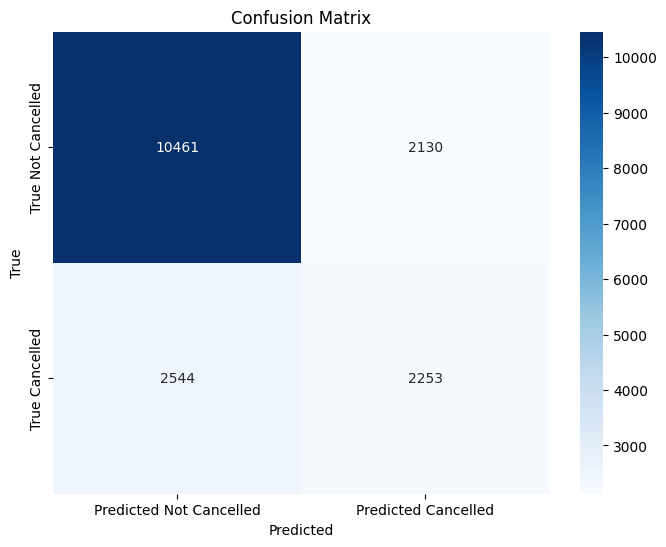

In [59]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Not Cancelled', 'Predicted Cancelled'], yticklabels=['True Not Cancelled', 'True Cancelled'])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()